In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Préparation des échantillons

In [2]:
def data_transformation(df):
    data = df.T
    data["path_to_image"]="../raw_data/IMG/"+data["image_name"]
    data['species'] = data['genus']+' '+data['specific_epithet'] 
    return data

In [3]:
def X_y_from_df(df, sample_size):
    data_sample = df.sample(sample_size, random_state = 818)
    image = []

    for i in data_sample['path_to_image'] :
        img = Image.open(i)
        img = img.resize((256,256))
        image.append(img_to_array(img))
 
    X = np.array(image)
    y = np.array(data_sample['species'])
    return X, y

In [4]:
#Data augmentation
augmentation = ImageDataGenerator(
    featurewise_center=True,
    brightness_range= (0,5),
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

In [5]:
df_train = data_transformation(pd.read_json('../raw_data/splits/train.json'))
df_val = data_transformation(pd.read_json('../raw_data/splits/val.json'))
df_test = data_transformation(pd.read_json('../raw_data/splits/test.json'))

X_val, y_val = X_y_from_df(df_val, 200)
X_test, y_test = X_y_from_df(df_test, 200)
X_train, y_train = X_y_from_df(df_train, 1000)

y_train = y_train.reshape(1000, 1)
y_val = y_val.reshape(200, 1)
y_test = y_test.reshape(200, 1)

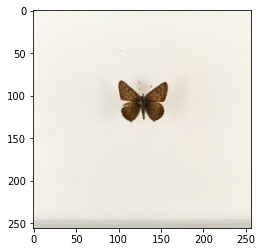

In [6]:
plt.imshow(array_to_img(X_train[0]))

In [7]:
X_train = np.expand_dims(X_train ,axis=0)
X_val = np.expand_dims(X_val ,axis=0)
X_test = np.expand_dims(X_test ,axis=0)

In [14]:
X_val.shape, type(X_val)

((1, 200, 256, 256, 3), numpy.ndarray)

In [ ]:
#X_train_aug=[]
#X_val_aug=[]
#X_test_aug=[]

#for imga in list(X_train):
#    X_train_aug.append(img_to_array(augmentation.flow(imga)))

#for imga in list(X_val):
#    X_val_aug.append(img_to_array(augmentation.flow(imga)))

#for imga in list(X_test):
#   X_test_aug.append(img_to_array(augmentation.flow(imga)))

In [ ]:
X_train_aug.shape

In [ ]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [ ]:
X_train_aug.shape

In [ ]:
plt.imshow(X_train_aug[2][13])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
ohe.fit(y_train)
y_train_cat = ohe.transform(y_train)
y_val_cat = ohe.transform(y_val)
y_test_cat = ohe.transform(y_test)

# Lancement du modèle

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.callbacks import EarlyStopping


def model_VGG16( X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat, image_size,  patience=2, learning_rate=0.001, nb_epochs=15, nb_couches_dense_layer=130):
    
    model = VGG16(weights="imagenet", include_top=False, input_shape = image_size)
    # Set the first layers to be untrainable
    model.trainable = False
    
    #add last layers
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(nb_couches_dense_layer, activation='relu')
    prediction_layer = layers.Dense(248, activation='softmax')
    model = models.Sequential([
        model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    
    #build model
    opt = optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    #set earlystopping
    es = EarlyStopping(monitor='val_loss', mode='max', patience=patience, verbose=1, restore_best_weights=True)
    
    #launch model
    history = model.fit(X_train, y_train_cat, 
                    validation_data=(X_val, y_val_cat), 
                    epochs=nb_epochs, 
                    batch_size=16, 
                    callbacks=[es])
    
    #evaluate model
    res_vgg = model.evaluate(X_test, y_test_cat)
    
    test_accuracy_vgg = res_vgg[-1]
    
    return (f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %"), history

# Courbes d'apprentissage

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history)

# Historique

In [ ]:
plt.imshow(X_train[0])

In [ ]:
X_train[0].shape

In [ ]:
model_VGG16(X_train, y_train_cat, X_val, y_val_cat, X_test, y_test_cat, X_train[0].shape, 5, 0.001, 15, 130)

In [ ]:
model = load_model()
model.summary()

In [ ]:
def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False
    
    return model

model
model = set_nontrainable_layers(model)

model.summary()

In [ ]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainables, and add additional trainable layers on top'''
    # $CHALLENGIFY_BEGIN
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(130, activation='relu')
    prediction_layer = layers.Dense(248, activation='softmax')
    
    
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    # $CHALLENGIFY_END
    return model

In [ ]:
model = add_last_layers(model)
model.summary()

In [ ]:
from tensorflow.keras import optimizers

def build_model():
    # $CHALLENGIFY_BEGIN    
    model = load_model()
    model = add_last_layers(model)
    
    opt = optimizers.Adam(learning_rate=1e-3)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
    # $CHALLENGIFY_END

In [ ]:
model = build_model()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():
    # $CHALLENGIFY_BEGIN
    model = VGG16(weights="imagenet", include_top=False, input_shape=image[0].shape)
    # $CHALLENGIFY_END
    
    return model

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
y_train

In [ ]:
y_train.shape

In [ ]:
y_val.shape

In [ ]:
y_cat.shape

In [ ]:
y_val_cat.shape

In [ ]:
X_train.shape

In [ ]:
X_val.shape

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='max', patience=2, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_cat, 
                    validation_data=(X_val, y_val_cat), 
                    epochs=20, 
                    batch_size=16, 
                    callbacks=[es])

In [ ]:
res_vgg = model.evaluate(X_test, y_test_cat)

test_accuracy_vgg = res_vgg[-1]

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")